## Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
train.csv
test.csv

Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Целевая переменная:
Price

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)


Описание датасета

- Id - идентификационный номер квартиры
- DistrictId - идентификационный номер района
- Rooms - количество комнат
- Square - площадь
- LifeSquare - жилая площадь
- KitchenSquare - площадь кухни
- Floor - этаж
- HouseFloor - количество этажей в доме
- HouseYear - год постройки дома
- Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
- Social_1, Social_2, Social_3 - социальные показатели местности
- Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
- Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
- Price - цена квартиры

In [61]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Определим функции

In [62]:
# выводит диаграмму разброса и гистограмму на одном поле
def plot_scat_hist(df, column_x, column_y, hist_bins):
    fig, ax = plt.subplots(nrows=1, ncols=3)
    ax1, ax2, ax3 = ax.flatten()
    ax1.scatter(df[column_x], df[column_y])
    ax2.hist(df[column_x], bins=hist_bins)
    ax3.hist(df[column_y], bins=hist_bins)
    
    ax1.set_title(f'x = {column_x}, y = {column_y}')
    ax2.set_title(column_x)
    ax3.set_title(column_y)
    
    fig.set_size_inches(20, 7)
    return None

In [63]:
# выводит диаграмму разброса 
def plot_scat(df, column_x:str, column_y:str):
    
    plt.scatter(df[column_x], df[column_y])
    plt.ylabel(column_y)
 
    plt.scatter(df[column_x])
    
    plt.xlabel(column_x)
    
    plt.title('train')
    return None

In [64]:
# выводит гистограмму 
def plot_hist(df_column_x, title, hist_bins=10):
    
    plt.hist(df_column_x, bins=hist_bins)  
    
    plt.title(title)
    return None

In [65]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Прогнозируемые значения')
    plt.ylabel('Истиные значения')
    plt.title('Прогнозирование обучающей выборки')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Прогнозируемые значения')
    plt.ylabel('Истиные значения')
    plt.title('Прогнозирование тестовой выборки')

    plt.show()

###  Загружаем данные из файлов

In [66]:
TEST = 'data/test.csv'
TRAIN = 'data/train.csv'
RESULT = 'data/result.csv'

In [67]:
df_test = pd.read_csv(TEST)
df_train = pd.read_csv(TRAIN)

### Посмотрим на содержание датасета

In [68]:
df_train.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [69]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [70]:
df_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


##### Избавимся от числовых типов в категориальных признаках: Id и DistrictId

In [71]:
df_train['Id'] = df_train['Id'].astype(str)
df_train['DistrictId'] = df_train['DistrictId'].astype(str)

df_test['Id'] = df_test['Id'].astype(str)
df_test['DistrictId'] = df_test['DistrictId'].astype(str)

##### Преобразуем категориальные признаки в числовые

In [72]:
df_train['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [73]:
df_train['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [74]:
df_train['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [75]:
df_train['Ecology_2'] = df_train['Ecology_2'].replace({'A':0, 'B':1})
df_train['Ecology_3'] = df_train['Ecology_3'].replace({'A':0, 'B':1})
df_train['Shops_2'] = df_train['Shops_2'].replace({'A':0, 'B':1})

df_test['Ecology_2'] = df_test['Ecology_2'].replace({'A':0, 'B':1})
df_test['Ecology_3'] = df_test['Ecology_3'].replace({'A':0, 'B':1})
df_test['Shops_2'] = df_test['Shops_2'].replace({'A':0, 'B':1})

### Обработка NaN-ов, выбросов и некорректных значений

Используя статистику, видим, что у следующих признаков максимальное значение значительно отличается от 75-го квантиля

In [76]:
square_list = ['Square', 'LifeSquare', 'KitchenSquare']

In [77]:
df_train.loc[:, square_list].describe()

,Square,LifeSquare,KitchenSquare
count,10000.000000,7887.000000,10000.000000
mean,56.315775,37.199645,6.273300
std,21.058732,86.241209,28.560917
min,1.136859,0.370619,0.000000
25%,41.774881,22.769832,1.000000
50%,52.513310,32.781260,6.000000
75%,65.900625,45.128803,9.000000
max,641.065193,7480.592129,2014.000000


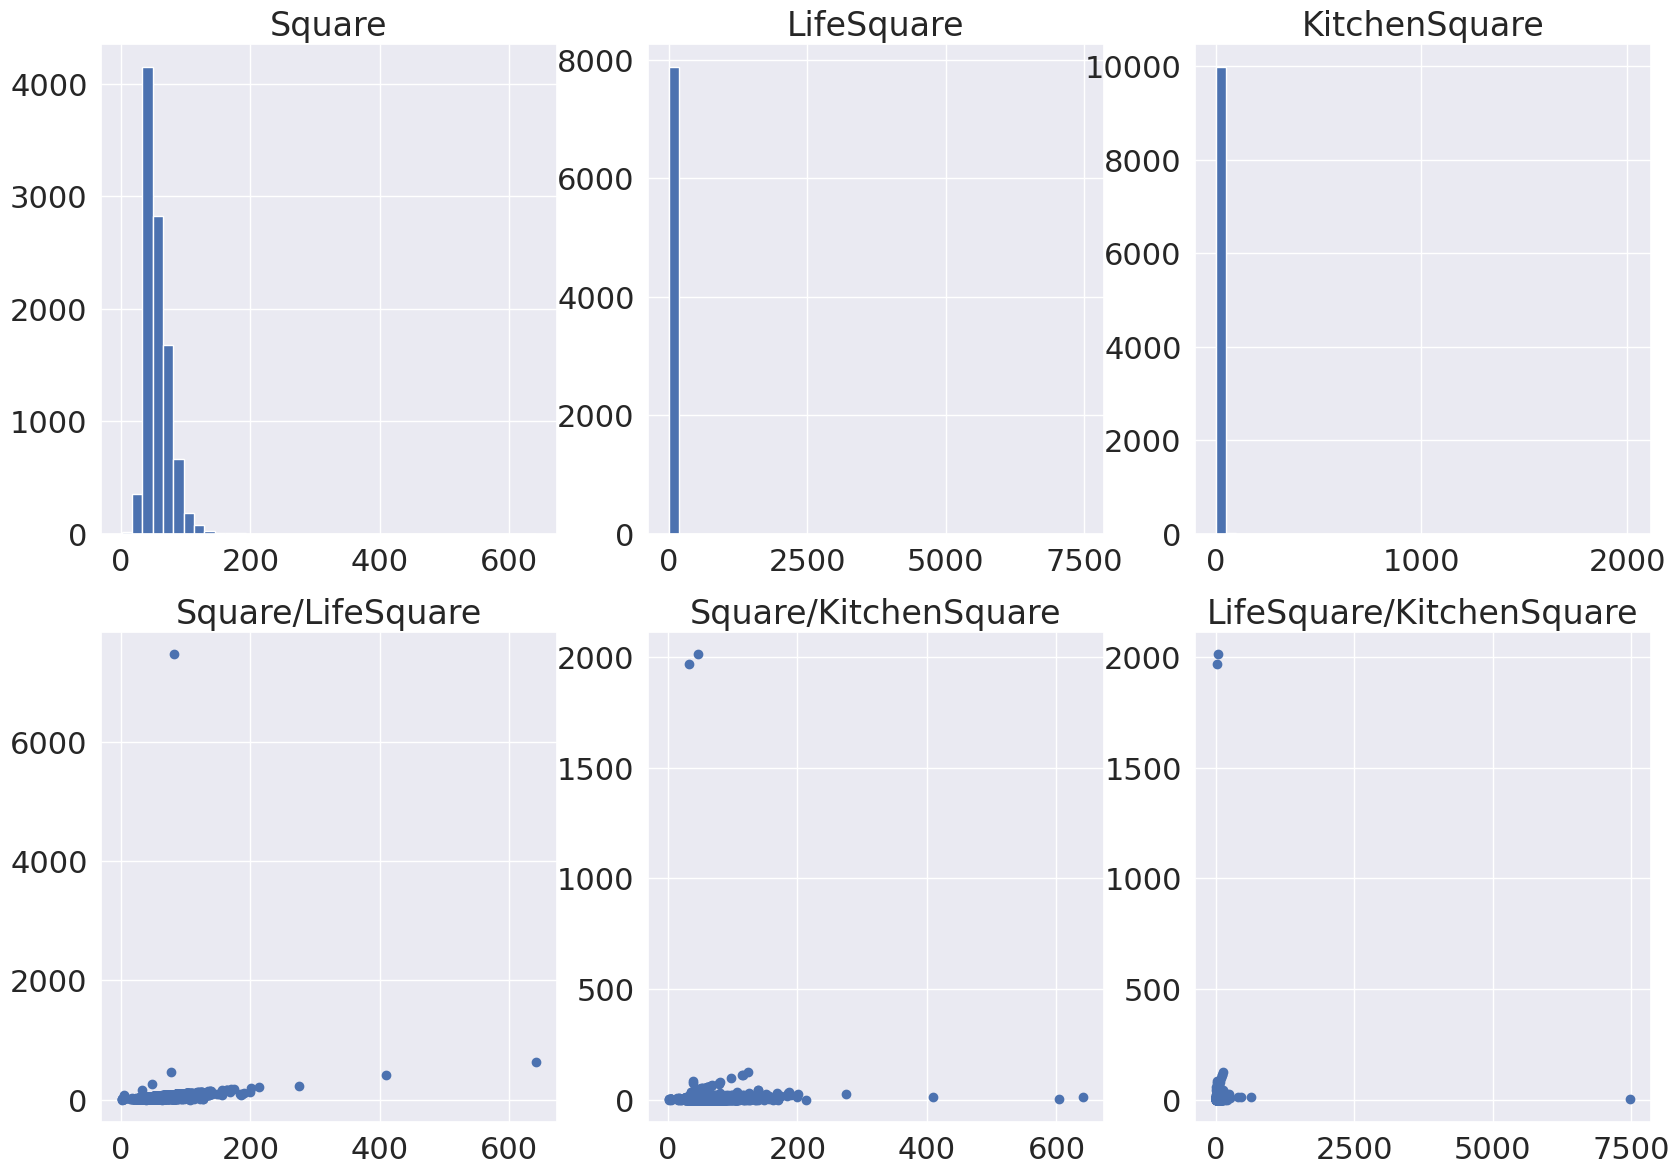

In [78]:
fig, ax = plt.subplots(nrows=2, ncols=3)
ax1, ax2, ax3, ax4, ax5, ax6 = ax.flatten()

ax1.hist(df_train['Square'], bins=40)
ax2.hist(df_train['LifeSquare'], bins=40)
ax3.hist(df_train['KitchenSquare'], bins=40)

ax4.scatter(df_train['Square'], df_train['LifeSquare'])
ax5.scatter(df_train['Square'], df_train['KitchenSquare'])
ax6.scatter(df_train['LifeSquare'], df_train['KitchenSquare'])

ax1.set_title('Square')
ax2.set_title('LifeSquare')
ax3.set_title('KitchenSquare')
ax4.set_title('Square/LifeSquare')
ax5.set_title('Square/KitchenSquare')
ax6.set_title('LifeSquare/KitchenSquare')

fig.set_size_inches(20, 14)

##### Обрежем выбросы

In [79]:
df_train = df_train[(df_train['Square'] < 150) & (df_train['Square'] > 20)]
df_train = df_train[(df_train['LifeSquare'] < 120) & (df_train['LifeSquare'] > 10)]
df_train = df_train[(df_train['KitchenSquare'] < 25) & (df_train['KitchenSquare'] > 5)]

df_test = df_test[(df_test['Square'] < 150) & (df_test['Square'] > 20)]
df_test = df_test[(df_test['LifeSquare'] < 120) & (df_test['LifeSquare'] > 10)]
df_test = df_test[(df_test['KitchenSquare'] < 25) & (df_test['KitchenSquare'] > 5)]

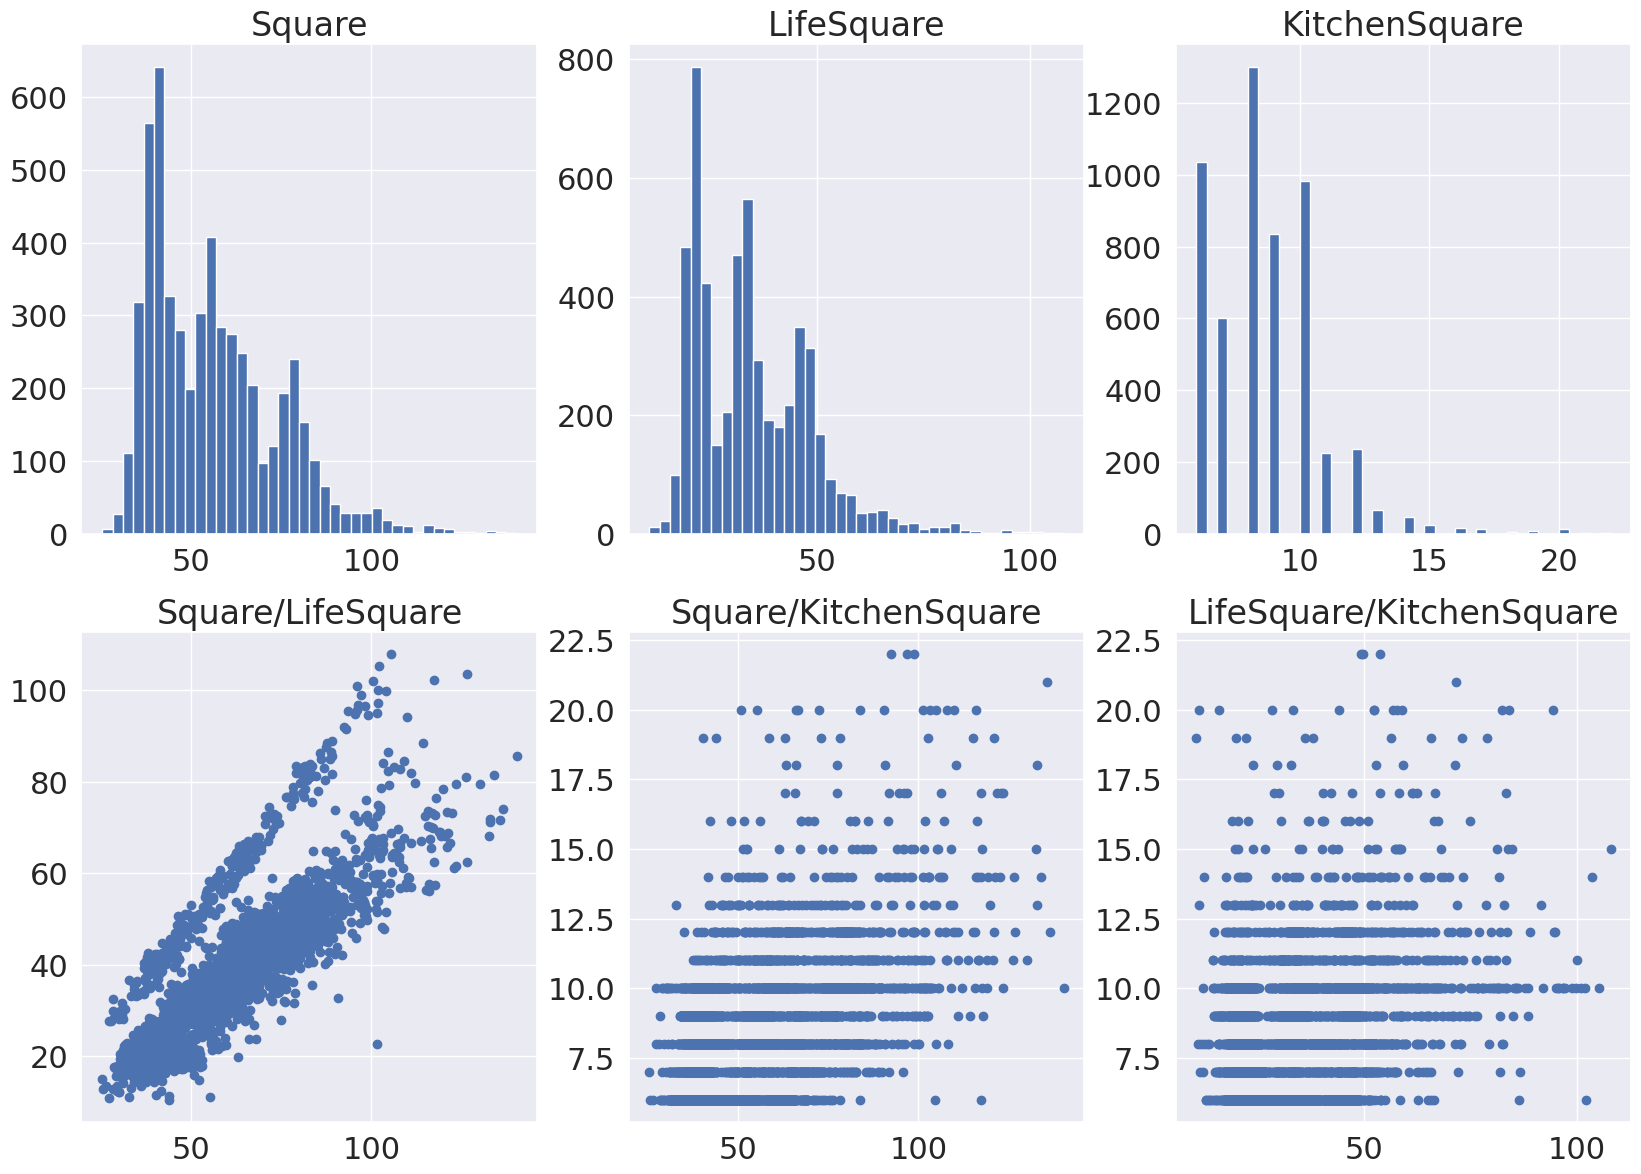

In [80]:
fig, ax = plt.subplots(nrows=2, ncols=3)
ax1, ax2, ax3, ax4, ax5, ax6 = ax.flatten()

ax1.hist(df_train['Square'], bins=40)
ax2.hist(df_train['LifeSquare'], bins=40)
ax3.hist(df_train['KitchenSquare'], bins=40)

ax4.scatter(df_train['Square'], df_train['LifeSquare'])
ax5.scatter(df_train['Square'], df_train['KitchenSquare'])
ax6.scatter(df_train['LifeSquare'], df_train['KitchenSquare'])

ax1.set_title('Square')
ax2.set_title('LifeSquare')
ax3.set_title('KitchenSquare')
ax4.set_title('Square/LifeSquare')
ax5.set_title('Square/KitchenSquare')
ax6.set_title('LifeSquare/KitchenSquare')

fig.set_size_inches(20, 14)

##### Есть записи, в которых жилая площадь привышает общюу:

In [81]:
df_train[df_train['Square'] < df_train['LifeSquare']].count()['Id']

103

Удалим эти записи

In [82]:
df_train = df_train[df_train['Square'] > df_train['LifeSquare']]

df_test = df_test[df_test['Square'] > df_test['LifeSquare']]

##### Так-же есть записи, в которых этаж квартиры больше этажности самого здания:

In [83]:
df_train[df_train['Floor'] > df_train['HouseFloor']].count()['Id']

563

Удалим эти данные

In [84]:
df_train = df_train[df_train['Floor'] <= df_train['HouseFloor']]

df_test = df_test[df_test['Floor'] <= df_test['HouseFloor']]

In [85]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4748 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             4748 non-null   object 
 1   DistrictId     4748 non-null   object 
 2   Rooms          4748 non-null   float64
 3   Square         4748 non-null   float64
 4   LifeSquare     4748 non-null   float64
 5   KitchenSquare  4748 non-null   float64
 6   Floor          4748 non-null   int64  
 7   HouseFloor     4748 non-null   float64
 8   HouseYear      4748 non-null   int64  
 9   Ecology_1      4748 non-null   float64
 10  Ecology_2      4748 non-null   int64  
 11  Ecology_3      4748 non-null   int64  
 12  Social_1       4748 non-null   int64  
 13  Social_2       4748 non-null   int64  
 14  Social_3       4748 non-null   int64  
 15  Healthcare_1   2728 non-null   float64
 16  Helthcare_2    4748 non-null   int64  
 17  Shops_1        4748 non-null   int64  
 18  Shops_2 

Теперь у нас в датасете остался с NaN-ами только признак Healthcare_1. Посмотрим, нужен ли этот признак.
Для этого возьмем часть датасета, в которой присутствует этот признак и цену, и создадим для этой части датасэта кореляционную матрицу

In [86]:
df_train_H1 = df_train[~df_train['Healthcare_1'].isna()]

<AxesSubplot: >

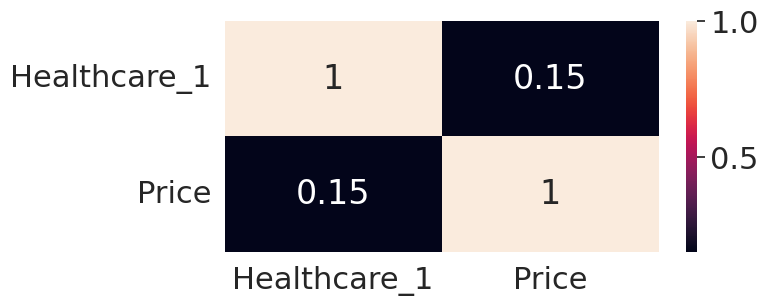

In [87]:
plt.figure(figsize=(7,3))
sns.set(font_scale=2)
sns.heatmap(df_train_H1.loc[:, ['Healthcare_1', 'Price']].corr(), annot=True)

Метрика Healthcare_1 не сильно влияет на Price, удалим эту колонку совсем.

In [88]:
df_train = df_train.drop(columns=['Healthcare_1'])

df_test = df_test.drop(columns=['Healthcare_1'])

In [89]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4748 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             4748 non-null   object 
 1   DistrictId     4748 non-null   object 
 2   Rooms          4748 non-null   float64
 3   Square         4748 non-null   float64
 4   LifeSquare     4748 non-null   float64
 5   KitchenSquare  4748 non-null   float64
 6   Floor          4748 non-null   int64  
 7   HouseFloor     4748 non-null   float64
 8   HouseYear      4748 non-null   int64  
 9   Ecology_1      4748 non-null   float64
 10  Ecology_2      4748 non-null   int64  
 11  Ecology_3      4748 non-null   int64  
 12  Social_1       4748 non-null   int64  
 13  Social_2       4748 non-null   int64  
 14  Social_3       4748 non-null   int64  
 15  Helthcare_2    4748 non-null   int64  
 16  Shops_1        4748 non-null   int64  
 17  Shops_2        4748 non-null   int64  
 18  Price   

##### Не корректные данные есть в поле HouseYear - отсеим все, что "из будущего"  

In [90]:
df_train[df_train['HouseYear'] > 2020].count()['Id']

1

In [91]:
df_train = df_train[df_train['HouseYear'] <= 2020]

df_test = df_test[df_test['HouseYear'] <= 2020]

##### Не корректные данные есть в поле Rooms - 0 комнат

In [92]:
df_train[df_train['Rooms'] < 1].count()['Id']

1

In [93]:
df_train = df_train[df_train['Rooms'] >= 1]

df_test = df_test[df_test['Rooms'] >= 1]

In [94]:
df_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
count,4746.000000,4746.000000,4746.000000,4746.000000,4746.000000,4746.000000,4746.000000,4746.000000,4746.000000,4746.000000,4746.000000,4746.000000,4746.000000,4746.000000,4746.000000,4746.000000,4746.000000
mean,1.961020,56.132497,34.111450,8.584071,7.986304,13.972819,1987.121997,0.122866,0.990518,0.963970,31.667720,6814.730088,6.365150,1.617994,4.930257,0.931732,238328.566353
std,0.889914,17.665369,13.178225,2.103986,4.706252,5.092557,18.004743,0.120425,0.096921,0.186385,16.129044,3964.143541,15.611162,1.512186,4.254445,0.252232,99076.193705
min,1.000000,25.410513,10.523868,6.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.236491,22.543371,7.000000,4.000000,9.000000,1974.000000,0.033494,1.000000,1.000000,22.000000,4447.250000,1.000000,0.000000,2.000000,1.000000,171318.345219
50%,2.000000,53.482133,32.478645,8.000000,7.000000,14.000000,1985.000000,0.090799,1.000000,1.000000,30.000000,5992.000000,3.000000,1.000000,4.000000,1.000000,214603.640594
75%,3.000000,66.285233,43.795372,10.000000,11.000000,17.000000,2003.000000,0.188784,1.000000,1.000000,42.000000,8429.000000,5.000000,3.000000,7.000000,1.000000,288990.212165
max,19.000000,140.242987,103.637322,22.000000,33.000000,48.000000,2020.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,6.000000,23.000000,1.000000,625678.644994


### Генерация новых признаков

In [95]:
# Соотношение жилой площади к общей площади квартиры
df_train['Life_Full_Square'] = df_train['LifeSquare'] / df_train['Square'] 

df_test['Life_Full_Square'] = df_test['LifeSquare'] / df_test['Square'] 

In [96]:
# Соотношение площади кухни к жилой площади квартиры
df_train['Kitchen_Life_Square'] = df_train['KitchenSquare'] / df_train['LifeSquare'] 

df_test['Kitchen_Life_Square'] = df_test['KitchenSquare'] / df_test['LifeSquare'] 

In [97]:
# Соотношение жилой площади квартиры к количеству комнат
df_train['LifeSquare_Rooms'] = df_train['LifeSquare'] / df_train['Rooms'] 

df_test['LifeSquare_Rooms'] = df_test['LifeSquare'] / df_test['Rooms'] 

In [98]:
# Медианная цена за кв.метр по району и году постройки
sq_1 = df_train.groupby(['DistrictId', 'HouseYear'], as_index=False).agg({'Price':'mean'}).rename(columns={'Price':'MedianPrice_by_DctYear'})
sq_1[sq_1['HouseYear'] == 2020]

,DistrictId,HouseYear,MedianPrice_by_DctYear
345,120,2020,536020.260344
752,169,2020,295304.011974
1597,53,2020,247976.085539
1797,62,2020,138770.715048


In [99]:
MedianPrice_by_DctYear_med = sq_1['MedianPrice_by_DctYear'].median()
MedianPrice_by_DctYear_med

229829.17408646943

In [100]:
# Медианная цена за кв.метр по району и году постройки (тест)
#sq_1_test = df_test.groupby(['DistrictId', 'HouseYear'], as_index=False).agg({'Price':'mean'}).rename(columns={'Price':'MedianPrice_by_DctYear'})
#sq_1_test[sq_1_test['HouseYear'] == 2020]

In [101]:
df_train = df_train.merge(sq_1, on=['DistrictId', 'HouseYear'], how='left')
df_test = df_test.merge(sq_1, on=['DistrictId', 'HouseYear'], how='left')

# В тесовом датасете есть значения комбинации ['DistrictId', 'HouseYear'], которых не было в train
# для них заменим NaN на медианную величину среди MedianPrice_by_DctYear
df_test['MedianPrice_by_DctYear'] = df_test['MedianPrice_by_DctYear'].fillna(MedianPrice_by_DctYear_med)

Попробуем ввести переменную, которая будет соберать совокупную привлекательность постройки:

In [102]:
curr_year = 2023
df_train['attractive_loc'] = (df_train['HouseYear']/curr_year) + ((df_train['Ecology_1'] + \
                            df_train['Ecology_2'] + df_train['Ecology_3'])/3 ) + \
                            ((df_train['Shops_1']/100) + df_train['Shops_2'])

df_test['attractive_loc'] = (df_test['HouseYear']/curr_year) + ((df_test['Ecology_1'] + \
                            df_test['Ecology_2'] + df_test['Ecology_3'])/3 ) + \
                            ((df_test['Shops_1']/100) + df_test['Shops_2'])


In [103]:
df_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Life_Full_Square,Kitchen_Life_Square,LifeSquare_Rooms,MedianPrice_by_DctYear,attractive_loc
count,4746.000000,4746.000000,4746.000000,4746.000000,4746.000000,4746.000000,4746.000000,4746.000000,4746.000000,4746.000000,...,4746.000000,4746.000000,4746.000000,4746.000000,4746.000000,4746.000000,4746.000000,4746.000000,4746.000000,4746.000000
mean,1.961020,56.132497,34.111450,8.584071,7.986304,13.972819,1987.121997,0.122866,0.990518,0.963970,...,6.365150,1.617994,4.930257,0.931732,238328.566353,0.601490,0.282132,18.564482,238328.566353,2.655751
std,0.889914,17.665369,13.178225,2.103986,4.706252,5.092557,18.004743,0.120425,0.096921,0.186385,...,15.611162,1.512186,4.254445,0.252232,99076.193705,0.103989,0.112732,5.647323,85805.917141,0.268237
min,1.000000,25.410513,10.523868,6.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,59174.778028,0.222840,0.058716,1.146278,64298.216337,1.440916
25%,1.000000,41.236491,22.543371,7.000000,4.000000,9.000000,1974.000000,0.033494,1.000000,1.000000,...,1.000000,0.000000,2.000000,1.000000,171318.345219,0.541345,0.202465,15.516917,181700.413131,2.685516
50%,2.000000,53.482133,32.478645,8.000000,7.000000,14.000000,1985.000000,0.090799,1.000000,1.000000,...,3.000000,1.000000,4.000000,1.000000,214603.640594,0.593375,0.261214,17.253847,218472.453136,2.711507
75%,3.000000,66.285233,43.795372,10.000000,11.000000,17.000000,2003.000000,0.188784,1.000000,1.000000,...,5.000000,3.000000,7.000000,1.000000,288990.212165,0.642944,0.347381,20.699124,270487.278622,2.770481
max,19.000000,140.242987,103.637322,22.000000,33.000000,48.000000,2020.000000,0.521867,1.000000,1.000000,...,141.000000,6.000000,23.000000,1.000000,625678.644994,0.999949,1.805420,103.637322,625678.644994,2.892738


In [104]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2394 entries, 0 to 2393
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Id                      2394 non-null   object 
 1   DistrictId              2394 non-null   object 
 2   Rooms                   2394 non-null   float64
 3   Square                  2394 non-null   float64
 4   LifeSquare              2394 non-null   float64
 5   KitchenSquare           2394 non-null   float64
 6   Floor                   2394 non-null   int64  
 7   HouseFloor              2394 non-null   float64
 8   HouseYear               2394 non-null   int64  
 9   Ecology_1               2394 non-null   float64
 10  Ecology_2               2394 non-null   int64  
 11  Ecology_3               2394 non-null   int64  
 12  Social_1                2394 non-null   int64  
 13  Social_2                2394 non-null   int64  
 14  Social_3                2394 non-null   

### Построим корелляционную матрицу по всем признакам

/tmp/ipykernel_7207/3890439596.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_train.corr(), annot=True, cmap="YlOrBr")


<AxesSubplot: >

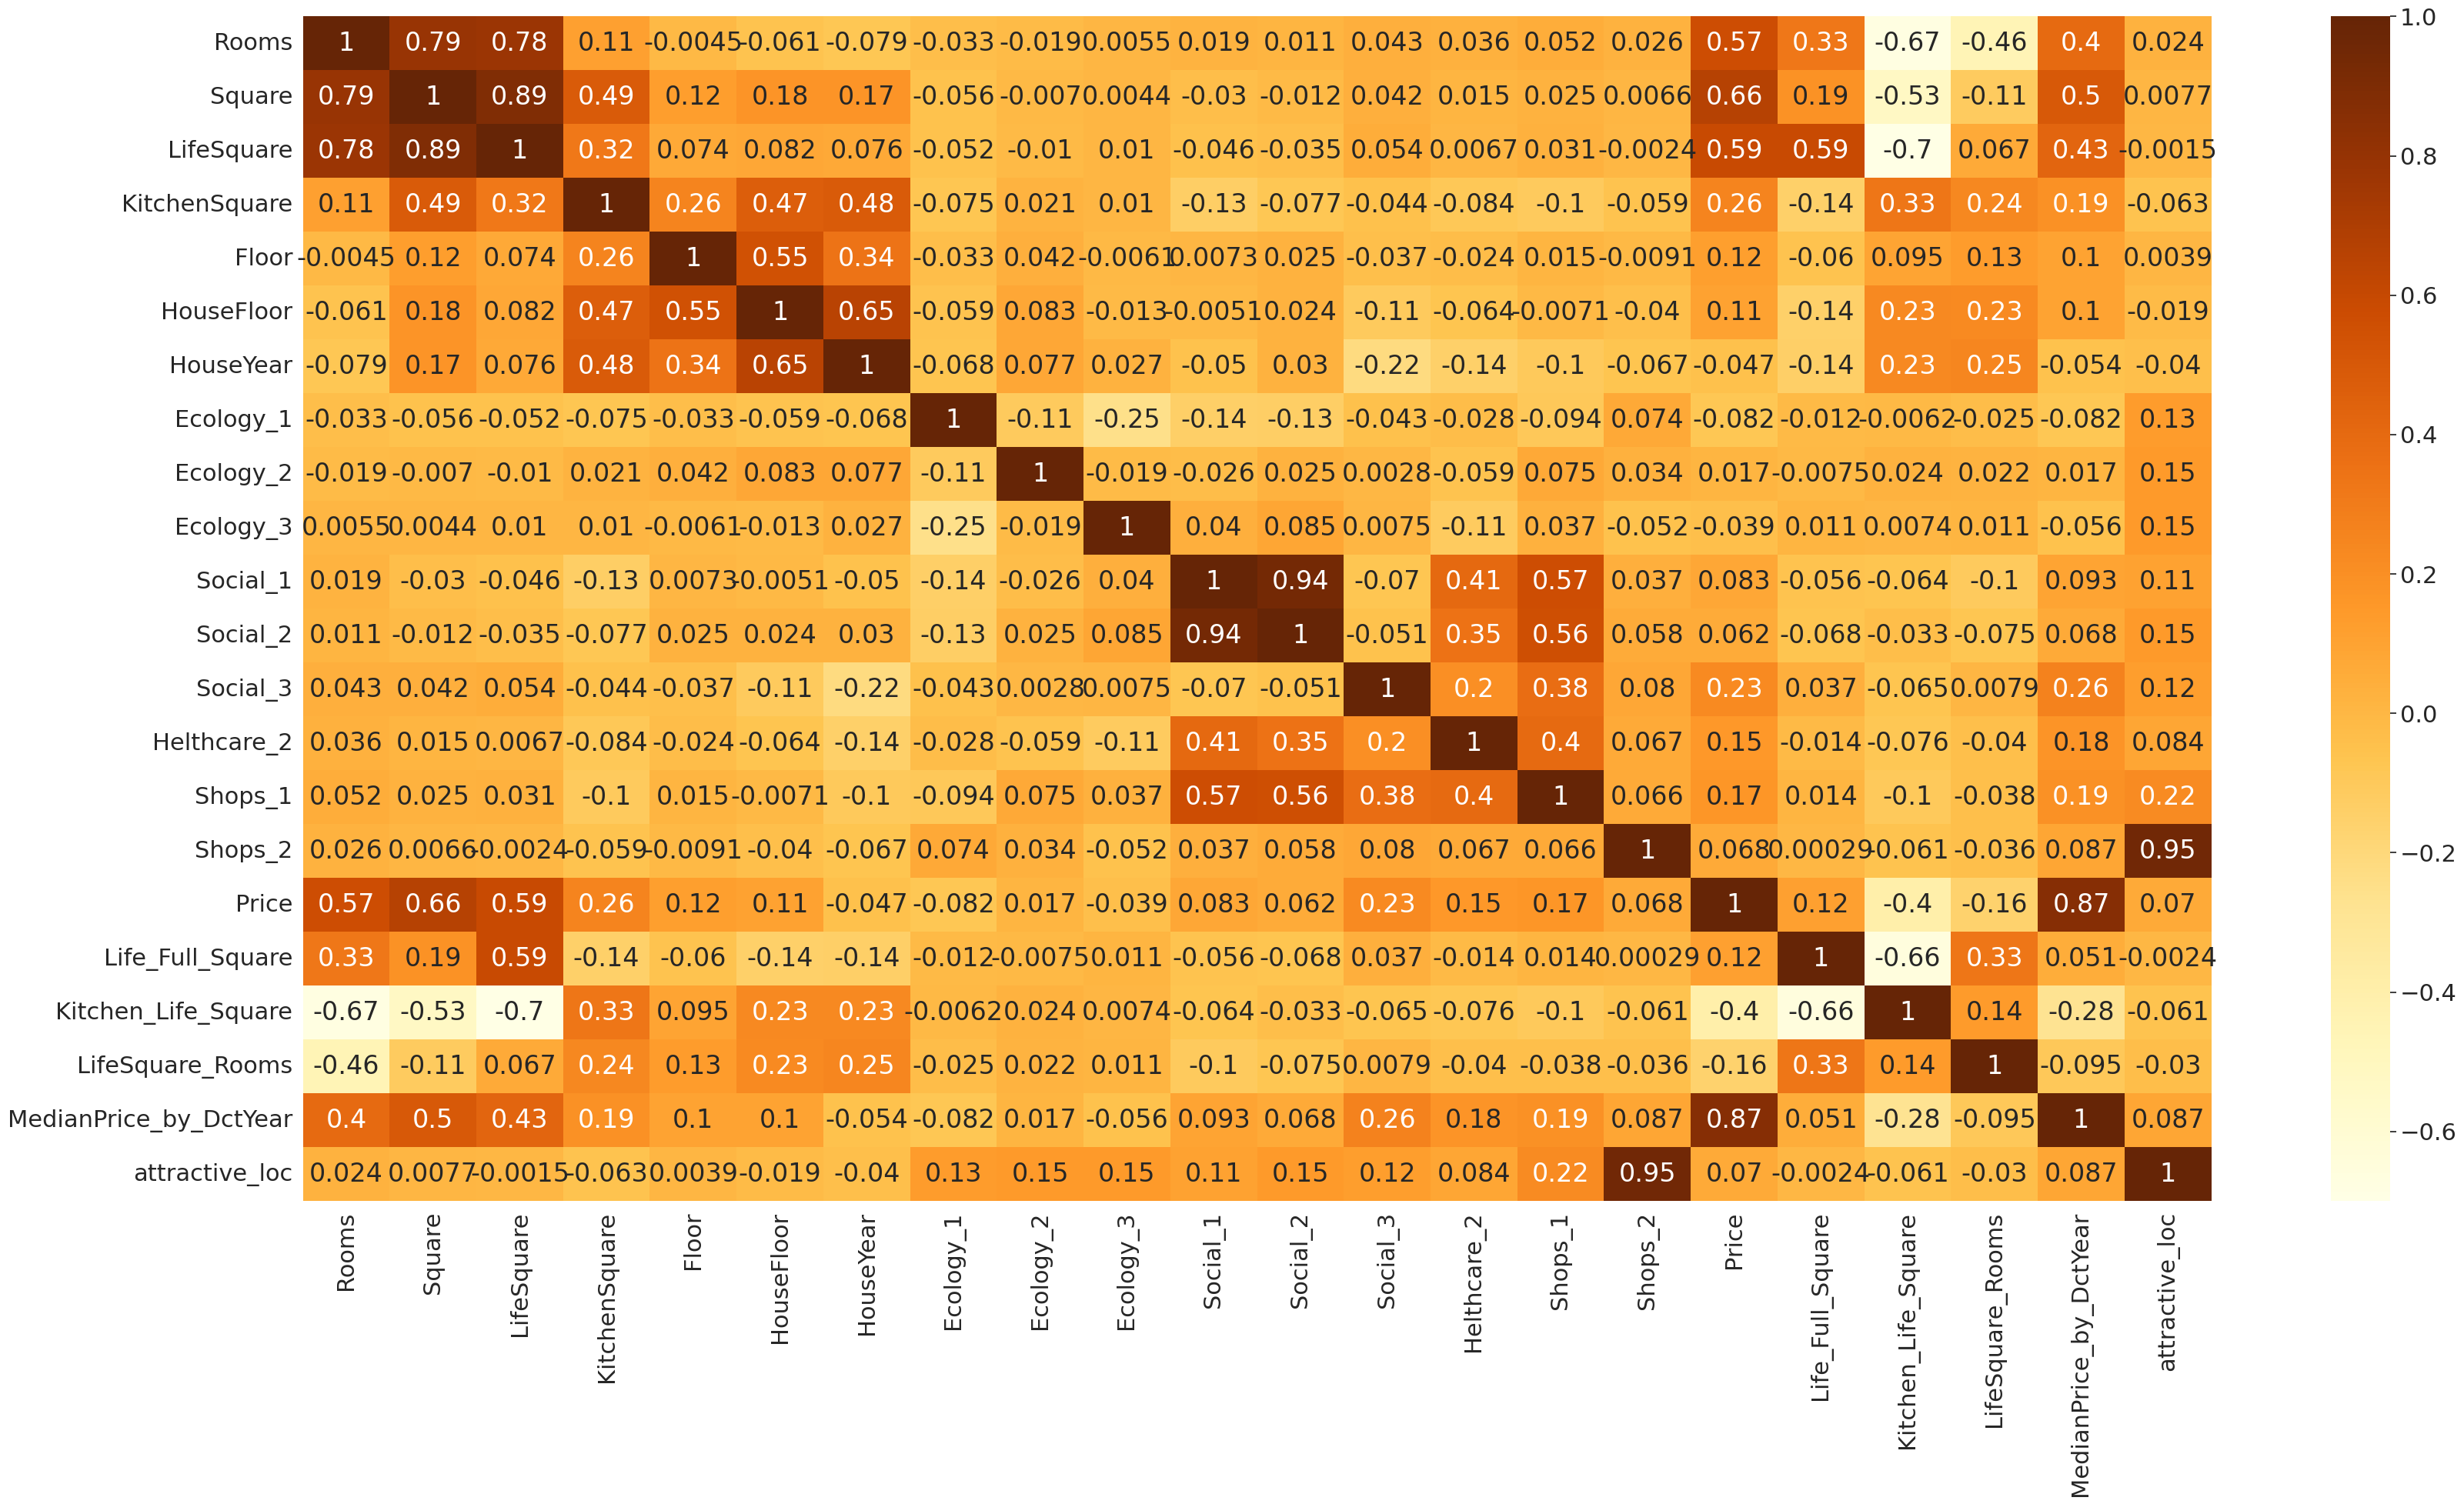

In [105]:
plt.figure(figsize=(40,20))
sns.set(font_scale=2)
sns.heatmap(df_train.corr(), annot=True, cmap="YlOrBr")

In [106]:
#  Уберем признаки:
to_drop = ['Kitchen_Life_Square', 'Shops_2', 'LifeSquare', 'Rooms', 'Social_2']
df = df_train.drop(columns=to_drop)

In [107]:
features = list(set(df_train.columns) - set(to_drop) - set(['Price']))

In [108]:
df.head(5)

,Id,DistrictId,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_3,Helthcare_2,Shops_1,Price,Life_Full_Square,LifeSquare_Rooms,MedianPrice_by_DctYear,attractive_loc
0,14038,35,47.981561,6.0,7,9.0,1969,0.089040,1,1,33,5,0,11,184966.930730,0.613626,14.721375,189571.162921,2.779654
1,15053,41,65.683640,8.0,7,9.0,1978,0.000070,1,1,46,1,1,16,300009.450063,0.609734,13.349848,300009.450063,2.804446
2,5809,58,53.352981,9.0,8,17.0,1977,0.437885,1,1,23,3,0,5,175616.227217,0.988352,26.365756,206300.329337,2.839890
3,10783,99,39.649192,7.0,11,12.0,1976,0.012339,1,1,35,1,2,4,150226.531644,0.599663,23.776169,154133.308873,2.687547
4,12915,59,80.384479,12.0,5,17.0,2011,0.309479,1,1,35,4,0,6,215898.447742,0.580755,15.561240,137935.805409,2.823895


#### Масштабируем признаки

In [109]:
scaler = StandardScaler()
scaler.fit(df[features])

StandardScaler()

### Разбиение на train и test

In [110]:
X = df[features]
y = df['Price']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

In [111]:
st_features = scaler.transform(df[features])
st_features

array([[-0.46145623,  0.08260999, -0.6805901 , ...,  0.4619637 ,
        -0.97659052,  1.42683315],
       [ 0.54072741,  0.88869435, -0.92347905, ...,  0.55440011,
        -0.97659052,  2.60219854],
       [-0.15735921, -0.5374549 ,  1.38155655, ...,  0.68655126,
         0.59449498,  0.01639469],
       ...,
       [-0.82718287, -0.10340947,  0.34971292, ..., -3.54370676,
        -0.19104777,  0.01639469],
       [-0.70936846, -0.10340947, -0.29121442, ..., -0.74783575,
        -1.76213327,  0.01639469],
       [-0.98880993, -0.28942894,  0.45927345, ...,  0.27815436,
         0.59449498,  0.72161392]])

In [112]:
df[features] = pd.DataFrame(st_features, columns=features)
df.head()

,Id,DistrictId,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_3,Helthcare_2,Shops_1,Price,Life_Full_Square,LifeSquare_Rooms,MedianPrice_by_DctYear,attractive_loc
0,1.159351,-0.532055,-0.461456,-1.228308,-0.209595,-0.976591,-1.006618,-0.280920,0.097839,0.193331,0.082610,-0.087456,-1.070083,1.426833,184966.930730,0.116717,-0.680590,-0.568289,0.461964
1,1.367397,-0.402005,0.540727,-0.277631,-0.209595,-0.976591,-0.506698,-1.019796,0.097839,0.193331,0.888694,-0.343710,-0.408719,2.602199,300009.450063,0.079282,-0.923479,0.718918,0.554400
2,-0.527355,-0.033531,-0.157359,0.197707,0.002910,0.594495,-0.562244,2.616174,0.097839,0.193331,-0.537455,-0.215583,-1.070083,0.016395,175616.227217,3.720601,1.381557,-0.373303,0.686551
3,0.492171,0.855142,-0.933184,-0.752970,0.640427,-0.387433,-0.617791,-0.917905,0.097839,0.193331,0.206623,-0.343710,0.252645,-0.218678,150226.531644,-0.017570,0.922957,-0.981332,0.118549
4,0.929169,-0.011856,1.372999,1.623723,-0.634607,0.594495,1.326346,1.549786,0.097839,0.193331,0.206623,-0.151520,-1.070083,0.251468,215898.447742,-0.199416,-0.531855,-1.170121,0.626914


### Построение модели

#### Обучение

In [113]:
rf_model = RandomForestRegressor(n_estimators=50, min_samples_leaf=1, max_depth=25, min_samples_split=10)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=25, min_samples_split=10, n_estimators=50)

#### Кросс-валидация

In [114]:
cv = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=42))
cv

array([0.82663272, 0.85009642, 0.85755621, 0.8258226 , 0.8497812 ])

In [115]:
cv.mean()

0.8419778308832051

#### Оценка модели

Train R2:	0.955
Test R2:	0.85


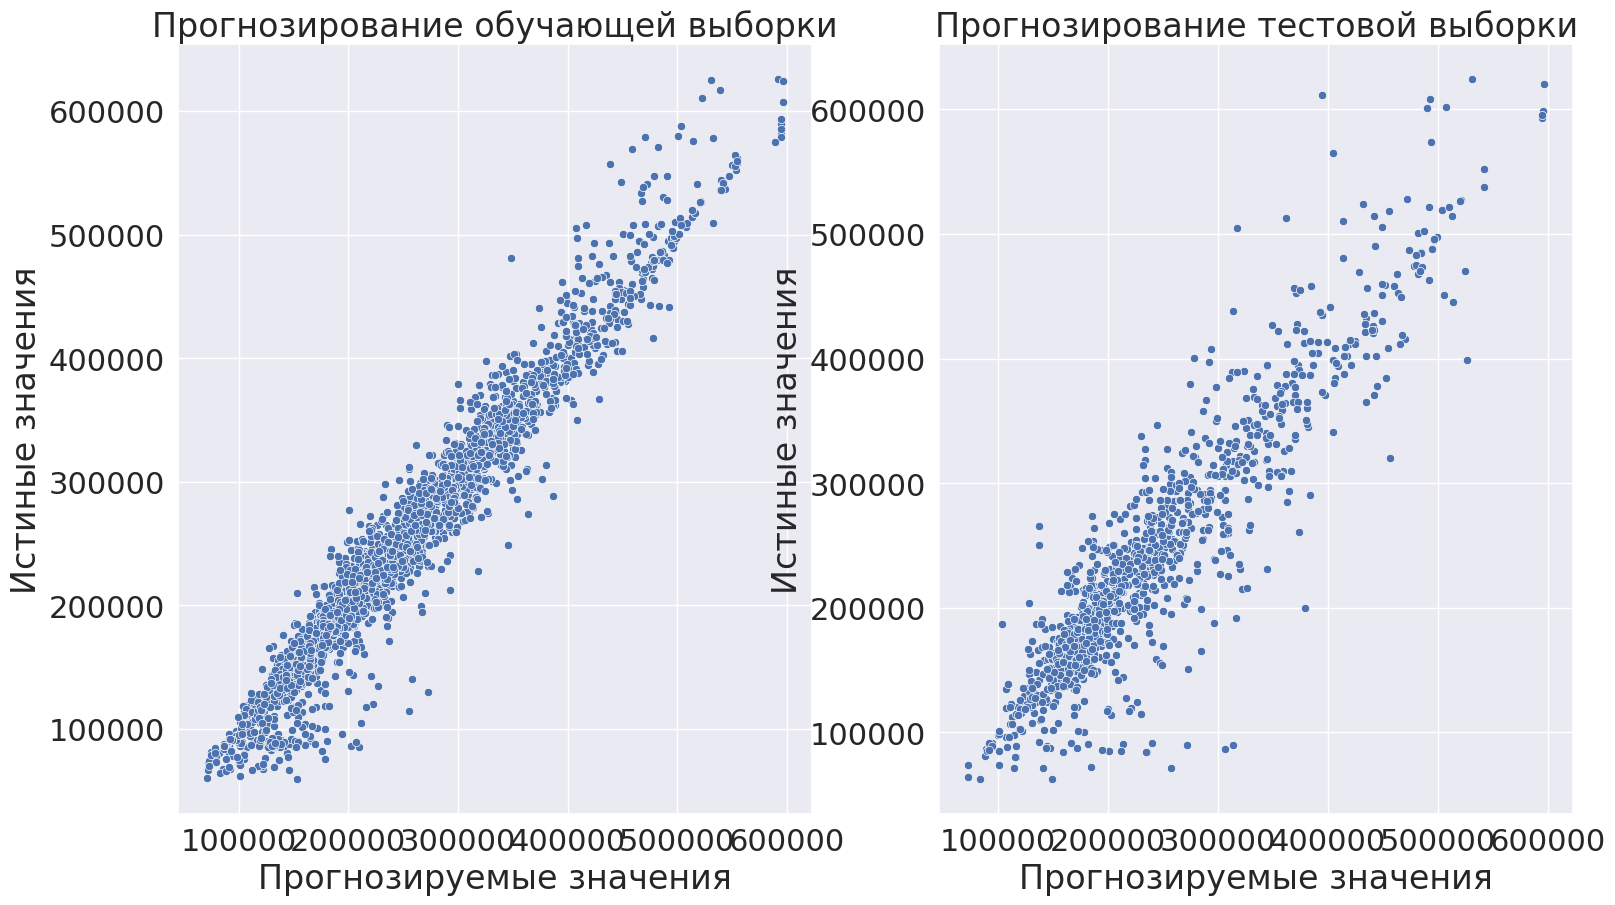

In [116]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

#### Важность признаков

In [117]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
3,MedianPrice_by_DctYear,0.765822
0,Square,0.134695
2,LifeSquare_Rooms,0.012408
1,Social_1,0.010665
6,Id,0.009842
4,Life_Full_Square,0.009585
10,Social_3,0.008450
12,DistrictId,0.007652
8,HouseYear,0.007367
15,attractive_loc,0.006518


### Предсказания на тестовом датасете

#### Масштабируем признаки

In [118]:
st_features = scaler.transform(df_test[features])

In [119]:
df[features] = pd.DataFrame(st_features, columns=features)
df.head()

,Id,DistrictId,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_3,Helthcare_2,Shops_1,Price,Life_Full_Square,LifeSquare_Rooms,MedianPrice_by_DctYear,attractive_loc
0,-1.569427,-0.033531,-0.353829,-1.228308,-0.422101,0.005338,-0.839978,1.555766,0.097839,0.193331,-1.281533,-0.343710,-1.070083,-1.158971,184966.930730,0.661085,-0.327285,0.310894,0.332224
1,1.492634,-0.271955,0.957574,0.197707,2.977990,1.576423,1.104159,-0.174346,0.097839,0.193331,-0.537455,-0.215583,0.914009,-0.453751,300009.450063,1.053818,1.311545,-0.703724,0.249672
2,-0.590281,-0.597079,-0.449435,-1.228308,-0.634607,0.005338,-0.839978,0.106168,0.097839,0.193331,0.888694,-0.023393,0.914009,1.426833,175616.227217,0.772180,-0.378212,-0.327138,0.525420
3,-0.853054,0.790117,0.914009,0.197707,1.915462,0.594495,0.548691,-0.678914,0.097839,0.193331,1.322740,-0.151520,-0.408719,-0.218678,150226.531644,0.331963,-0.574060,0.017036,0.193018
4,0.646924,-1.160628,1.363653,0.197707,1.065439,0.594495,1.492986,0.999389,0.097839,0.193331,-1.653572,-0.407774,-1.070083,-1.158971,215898.447742,-0.070846,-0.474209,-1.040897,0.326370


#### Предсказываем цены для тестового датасета

In [120]:
X_test = df_test[features]

In [121]:
y_test_preds = rf_model.predict(X_test)

### Посмотрим гистограммы распределения для реальных и спрогнозированных цен

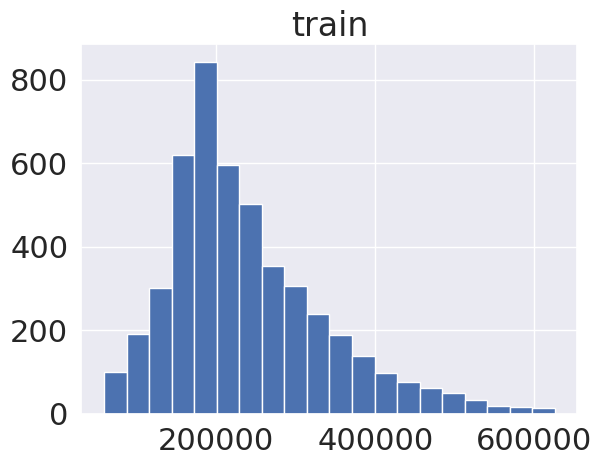

In [122]:
plot_hist(df_train['Price'], title='train', hist_bins=20)

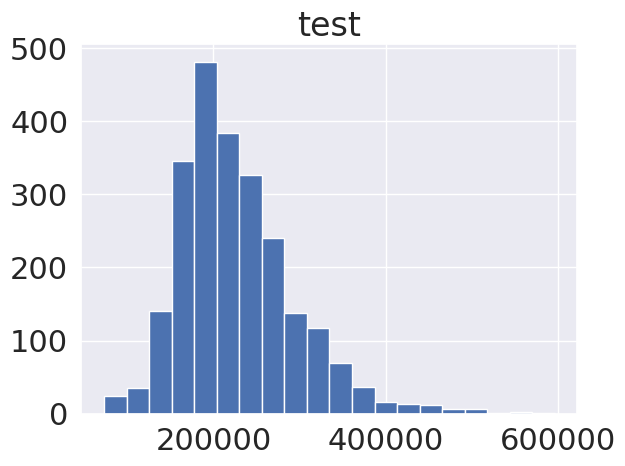

In [123]:
plot_hist(y_test_preds, title='test', hist_bins=20)

In [124]:
df_test['Price'] = y_test_preds
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,Life_Full_Square,Kitchen_Life_Square,LifeSquare_Rooms,MedianPrice_by_DctYear,attractive_loc,Price
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,1,0,0,1,0.670229,0.179465,16.716391,265002.283090,2.744856,235733.183687
1,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,3,3,3,1,0.711064,0.173274,25.970421,177951.251258,2.722715,175888.737876
2,5502,32,2.0,48.193897,32.857644,6.0,5,14.0,1972,0.135650,...,6,3,11,1,0.681780,0.182606,16.428822,210261.180271,2.796673,216801.158197
3,4220,96,3.0,72.277106,45.968758,9.0,17,17.0,1997,0.041116,...,4,1,4,1,0.636007,0.195785,15.322919,239790.196596,2.707520,302837.295107
4,11538,6,3.0,80.219400,47.660260,9.0,13,17.0,2014,0.243205,...,0,0,0,1,0.594124,0.188837,15.886753,149022.896053,2.743286,177355.842324


#### Сохраним результат в файл

In [125]:
df_test.to_csv(RESULT,columns=['Id', 'Price'], encoding='utf-8', index=False)